In [1]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dataorganizer)
  library(dplyr)
  library(magrittr)
  library(Matrix)
  library(readr)
  library(ggplot2)
  library(Seurat)
  library(sccore)
  library(patchwork)
})

theme_set(theme_bw())

## Load data

In [2]:
cell_annot <- DatasetPath('human_ovarian_cancer', 'Xenium_Prime_Ovarian_Cancer_FFPE_XRrun_cell_groups.csv') %>%
  read_csv(show_col_types=FALSE) %$% setNames(group, cell_id)

In [3]:
so <- DatasetPath('human_ovarian_cancer', 'cell_feature_matrix.h5') %>%
  Read10X_h5() %>% .$`Gene Expression` %>%
  CreateSeuratObject() %>% subset(cells=names(cell_annot))

so$cell_type <- cell_annot[colnames(so)]

so %<>% subset(cells=colnames(so)[
    (so$cell_type != 'Unassigned') & (so$nCount_RNA >= 25)
])

so

Genome matrix has multiple modalities, returning a list of matrices for this genome

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
5101 features across 373830 samples within 1 assay 
Active assay: RNA (5101 features, 0 variable features)
 1 layer present: counts

In [4]:
cell_meta <- DatasetPath('human_ovarian_cancer', 'cells.parquet') %>%
  arrow::read_parquet() %>% as.data.frame() %>% set_rownames(.$cell_id)

so@meta.data %<>% cbind(cell_meta[rownames(.),])

In [5]:
so[['spatial']] <- so@meta.data %>%
  select(x_centroid, y_centroid) %>% as.matrix() %>%
  set_colnames(c('spatial_1', 'spatial_2')) %>%
  CreateDimReducObject(key='spatial_', assay='RNA')

In [6]:
so$cell_type[so$cell_type == 'T and NK Cells'] <- 'T & NK Cells'
so$cell_type[so$cell_type == 'Stromal Associated Endothelial Cells'] <- 'Endothelial Cells'
so$cell_type[so$cell_type == 'Tumor Associated Endothelial Cells'] <- 'Endothelial Cells'

In [7]:
so$cell_type_full <- so$cell_type
so$cell_type[grep('Tumor Cells', so$cell_type_full)] <- 'Tumor Cells'

## Process

In [8]:
so %<>%
  NormalizeData() %>%
  FindVariableFeatures(selection.method="vst", nfeatures=2000) %>%
  ScaleData() %>%
  RunPCA(., features=VariableFeatures(.)) %>%
  FindNeighbors(dims=1:30) %>%
  RunUMAP(dims=1:30, n.epochs=500) %>%
  FindClusters(resolution=2, algorithm=2)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  CD47, LAPTM4B, H19, UCHL1, CP, EPCAM, PLXNB1, HMGA1, PVT1, TPX2 
	   SMC4, LCN2, MUC16, HSPE1, MLF1, TOP2A, CYP4B1, BIRC5, PABPC1L, TFRC 
	   MAL2, IFT57, ALCAM, RGL3, DSG2, DHCR24, CSE1L, IL1RAP, MYBL2, STMN1 
Negative:  DCN, LUM, MYH11, BGN, COL5A1, POSTN, C11orf96, C7, CCN1, CDKN1A 
	   CNN1, THY1, COL5A2, CXCL12, NR4A1, CTHRC1, THBS2, MMP14, SFRP4, CDH11 
	   TIMP3, MEG3, C4A, PDGFRB, C4B, AQP1, AEBP1, COL11A1, SLC2A3, SNAI2 
PC_ 2 
Positive:  MYH11, CNN1, C11orf96, PLN, SYNPO2, FAM107A, GRIA2, MRC1, MAOB, SYNM 
	   CP, AOC3, KCNMA1, GREB1, ADAMTS1, CSRP1, IGSF9B, CD8A, CIITA, C5AR1 
	   C2orf88, CD52, CCL14, TRBC1, CD163, RERG, MUC16, HSPA6, F13A1, KCNK15 
Negative:  COL5A1, LUM, BGN, CTHRC1, COL5A2, MMP14, THY1, COL11A1, THBS2, CDH11 
	   LOXL1, PLAU, SERPINH1, INHBA, DCN, POSTN, ADAMTS14, FAP, COL4A1, ADAM12 
	   TIMP2, LTBP2, SERPINE1, CXCL12, LOX, TIMP3, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 373830
Number of edges: 9176370

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.8434
Number of communities: 76
Elapsed time: 221 seconds


32 singletons identified. 44 final clusters.



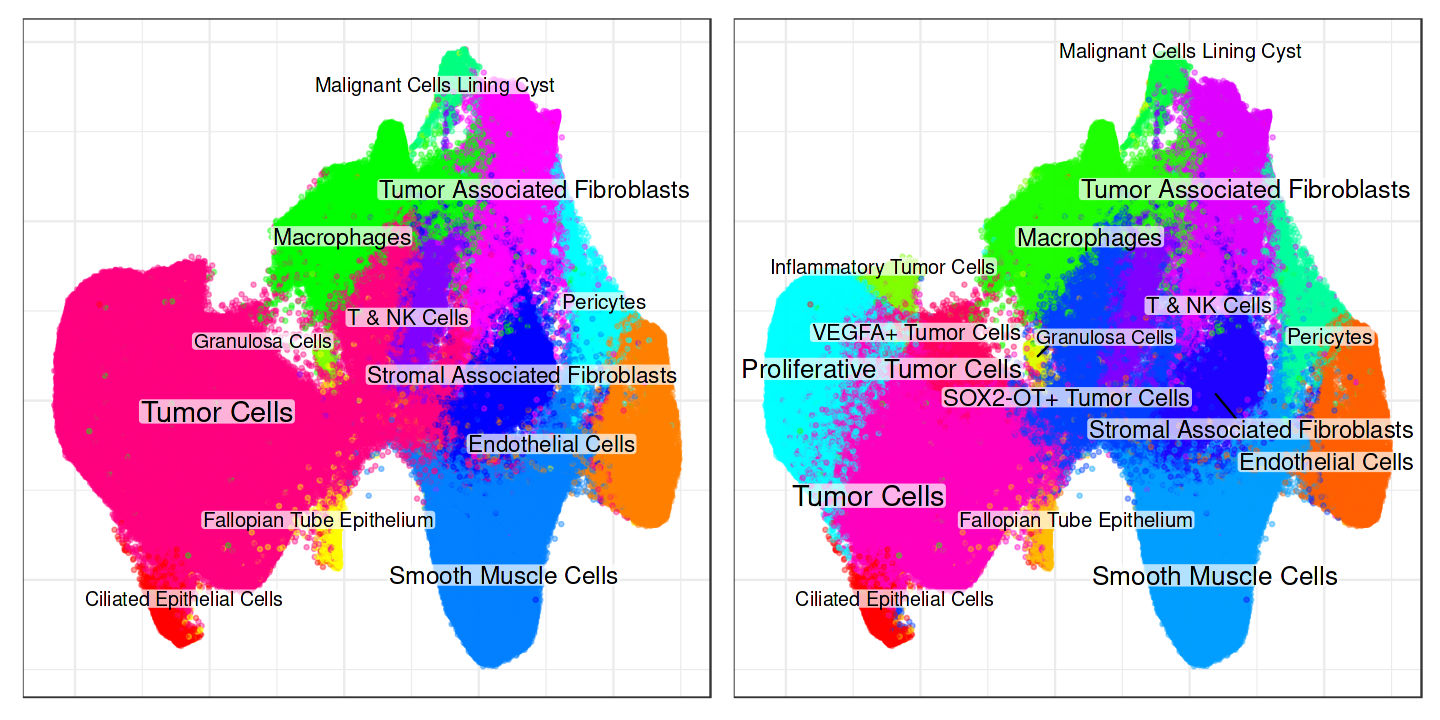

In [9]:
options(repr.plot.width=12, repr.plot.height=6)
c('cell_type', 'cell_type_full') %>% lapply(\(ct) {
  embeddingPlot(so, 'umap', groups=ct, font.size=c(4, 6))
}) %>% {.[[1]] | .[[2]]}

## Save

In [10]:
DatasetPath('human_ovarian_cancer', 'processed', 'so.rds') %>% write_rds(so, .)